In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acovf,acf,pacf
from sklearn.metrics import mean_squared_error

In [46]:
# import pytorch_lightning as pl
import lightning.pytorch as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, DeepAR
from pytorch_forecasting.metrics.distributions import MultivariateNormalDistributionLoss

In [3]:
store_df = pd.read_csv('data/store.csv')
test_df = pd.read_csv('data/test.csv')
train_df = pd.read_csv('data/train.csv')
sample_submission_df = pd.read_csv('data/sample_submission.csv')

/scratch/ipykernel_2133405/3598239639.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('data/train.csv')


In [4]:
train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


In [5]:
store_df

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


## Data preprocessing

#### Checking any problems with the data

In [6]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

The value 0 occurs in two data types

In [7]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [8]:
def one_hot_encode(df, column_name):
    one_hot_df = pd.get_dummies(df[column_name], prefix=column_name+"_", drop_first=False, dtype=int)
    new_cols = df.columns.drop(column_name)
    new_df = pd.concat([df[new_cols], one_hot_df], axis=1)
    return new_df

def preprocess_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df.loc[df['StateHoliday'] == 0, 'StateHoliday'] = '0'
    # df = one_hot_encode(df, 'StateHoliday')
    df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
    # df = df.iloc[::-1].reset_index(drop=True)
    
    return df
    

In [9]:
train_df = preprocess_data(train_df)
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,2,2013-01-01,0,0,0,0,a,1
1,1,3,2013-01-02,5530,668,1,0,0,1
2,1,4,2013-01-03,4327,578,1,0,0,1
3,1,5,2013-01-04,4486,619,1,0,0,1
4,1,6,2013-01-05,4997,635,1,0,0,1


In [10]:
test_df = preprocess_data(test_df)
test_df.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,40233,1,6,2015-08-01,1.0,0,0,1
1,39377,1,7,2015-08-02,0.0,0,0,1
2,38521,1,1,2015-08-03,1.0,1,0,1
3,37665,1,2,2015-08-04,1.0,1,0,1
4,36809,1,3,2015-08-05,1.0,1,0,1


## Exploring the data

In [11]:
# corr_df = train_df[list(train_df.columns[1:])].corr()
# corr_df

In [12]:
# fig = px.imshow(corr_df)
# fig.show("png")

Customers and Open columns are strongly correlated with Sales

#### Looking at the data of a random store

In [13]:
df_store_x = train_df[train_df['Store'] == 1011]
df_store_x

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
921243,1011,2,2013-01-01,0,0,0,0,a,1
921244,1011,3,2013-01-02,7049,900,1,0,0,1
921245,1011,4,2013-01-03,6377,802,1,0,0,1
921246,1011,5,2013-01-04,5981,793,1,0,0,1
921247,1011,6,2013-01-05,7963,1043,1,0,0,0
...,...,...,...,...,...,...,...,...,...
922180,1011,1,2015-07-27,10066,902,1,1,0,1
922181,1011,2,2015-07-28,8673,834,1,1,0,1
922182,1011,3,2015-07-29,7755,732,1,1,0,1
922183,1011,4,2015-07-30,9227,877,1,1,0,1


In [14]:
# store_corr_df = train_df[list(df_store_x.columns[1:])].corr()
# store_corr_df

In [15]:
# fig = px.imshow(store_corr_df)
# fig.show("png")

Same correlation is observed for this particular store

## Exploring LSTM model.

In [16]:
df_store_x.loc[:, "TimeIndex"] = range(0, len(df_store_x))

/scratch/ipykernel_2133405/359616140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_store_x.loc[:, "TimeIndex"] = range(0, len(df_store_x))


In [30]:
# df.astype({'col1': 'int32'}).dtypes
df_store_x = df_store_x.astype({'Store': 'str', 'DayOfWeek': 'str', 'Open': 'str', 'Promo': 'str', 'StateHoliday': 'str', 
                                'SchoolHoliday': 'str', 'Sales': 'float64'})

In [31]:
df_store_x.dtypes

Store                    object
DayOfWeek                object
Date             datetime64[ns]
Sales                   float64
Customers                 int64
Open                     object
Promo                    object
StateHoliday             object
SchoolHoliday            object
TimeIndex                 int64
dtype: object

In [32]:
df_store_x.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
921243,1011,2,2013-01-01,0.0,0,0,0,a,1,0
921244,1011,3,2013-01-02,7049.0,900,1,0,0,1,1
921245,1011,4,2013-01-03,6377.0,802,1,0,0,1,2
921246,1011,5,2013-01-04,5981.0,793,1,0,0,1,3
921247,1011,6,2013-01-05,7963.0,1043,1,0,0,0,4


In [33]:
df_store_x.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,TimeIndex
922180,1011,1,2015-07-27,10066.0,902,1,1,0,1,937
922181,1011,2,2015-07-28,8673.0,834,1,1,0,1,938
922182,1011,3,2015-07-29,7755.0,732,1,1,0,1,939
922183,1011,4,2015-07-30,9227.0,877,1,1,0,1,940
922184,1011,5,2015-07-31,10134.0,1021,1,1,0,1,941


In [34]:
# train_df.StateHoliday.unique()
df_store_x.Open.unique()

array(['0', '1'], dtype=object)

In [35]:
dataset = TimeSeriesDataSet(
    df_store_x,
    time_idx="TimeIndex",
    target="Sales",
    group_ids=["Store"],
    max_encoder_length=365,
    max_prediction_length=60,
    time_varying_unknown_reals=["Sales"],
    static_categoricals=["Store"],
    # time_varying_known_reals=["DayOfWeek"],
    time_varying_known_categoricals=["DayOfWeek", "Open", "Promo", "StateHoliday"],
)

In [36]:
train_dataset = dataset.to_dataloader(train=True, batch_size=32)
val_dataset = dataset.to_dataloader(train=False, batch_size=32)

In [38]:
model = DeepAR.from_dataset(
    dataset,
    learning_rate=0.01,
    hidden_size=32,
    rnn_layers=2,
    cell_type='LSTM',
    loss=MultivariateNormalDistributionLoss()
)

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [47]:
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="auto",
    enable_model_summary=True,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [48]:
# trainer = Trainer(
#     max_epochs=50,
#     accelerator="auto",
#     enable_model_summary=True,
# )

In [49]:
trainer.fit(model, train_dataset, val_dataset)

Missing logger folder: /projectnb/ivc-ml/harshk/rossmann-sales-forecast/lightning_logs

  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 52    
3 | rnn                    | LSTM                               | 14.3 K
4 | distribution_projector | Linear                             | 396   
------------------------------------------------------------------------------
14.8 K    Trainable params
0         Non-trainable params
14.8 K    Total params
0.059     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/projectnb/ivc-ml/harshk/miniconda3/envs/notebook/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (16) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

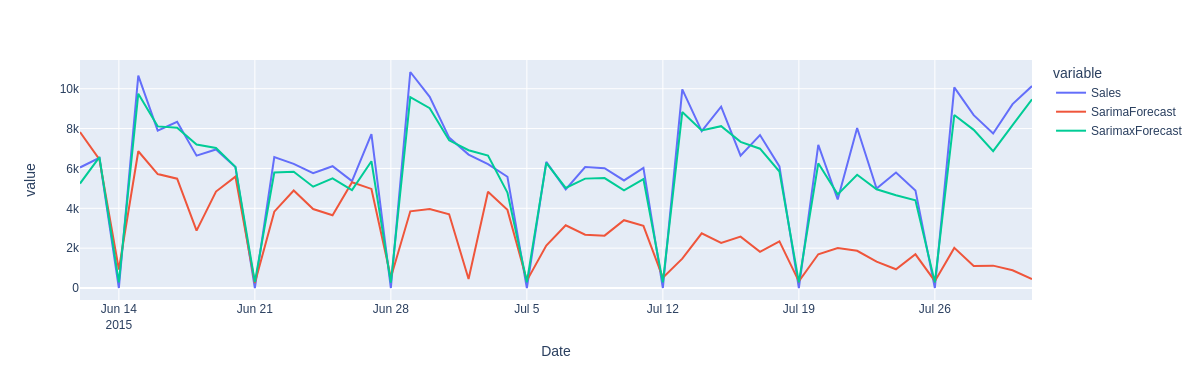

In [44]:
fig = px.line(forecast_df, x="Date", y=["Sales", "SarimaForecast", "SarimaxForecast"], width=1200, height=380)
fig.show("png")

## Conclusion